<a href="https://colab.research.google.com/github/mark-ford123/applied_ml_cw_2025_mf/blob/main/coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras

from keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np

In [3]:
!kaggle datasets download -d nolasthitnotomorrow/radioml2016-deepsigcom
!unzip "/content/radioml2016-deepsigcom.zip" -d "/content/"

Dataset URL: https://www.kaggle.com/datasets/nolasthitnotomorrow/radioml2016-deepsigcom
License(s): CC-BY-NC-SA-4.0
 99% 277M/279M [00:13<00:00, 26.2MB/s]
100% 279M/279M [00:13<00:00, 21.8MB/s]
Archive:  /content/radioml2016-deepsigcom.zip
  inflating: /content/RML2016.10a_dict.pkl  


In [4]:
import pickle
with open("RML2016.10a_dict.pkl", "rb") as f:
  Xd = pickle._Unpickler(f)
  Xd.encoding = "latin1"
  Xd = Xd.load()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset (already unpickled)
Xd_dict = Xd  # Assuming Xd is your unpickled dataset

# Extract Modulations and SNRs
modulations = sorted(set([key[0] for key in Xd_dict.keys()]))  # Unique modulation types
snrs = sorted(set([key[1] for key in Xd_dict.keys()]))  # Unique SNR values

X = []  # Features (IQ samples)
y = []  # Labels (Modulation type)

# Iterate through the dictionary and extract data
for (mod_type, snr), samples in Xd_dict.items():
    for sample in samples:
        X.append(sample)  # Each sample is (2, 128)
        y.append(mod_type)  # The label is the modulation type

# Convert lists to NumPy arrays
X = np.array(X)  # Shape: (num_samples, 2, 128)
y = np.array(y)  # Shape: (num_samples,)

# Convert modulation labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert to integers

# One-hot encode the labels for TensorFlow
y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(modulations))

# Split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")  # (num_samples, 2, 128)
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")  # (num_samples, num_classes)
print(f"y_test shape: {y_test.shape}")


X_train shape: (176000, 2, 128)
X_test shape: (44000, 2, 128)
y_train shape: (176000, 11)
y_test shape: (44000, 11)


In [6]:
# Reshape for CNN (channels last format)
X_train = X_train.reshape(-1, 128, 2, 1)  # Add a channel dimension
X_test = X_test.reshape(-1, 128, 2, 1)

print(f"Reshaped X_train: {X_train.shape}")  # (num_samples, 128, 2, 1)
print(f"Reshaped X_test: {X_test.shape}")


Reshaped X_train: (176000, 128, 2, 1)
Reshaped X_test: (44000, 128, 2, 1)


In [8]:
from tf.keras.models import Sequential
from tf.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN Model
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(128,2,1), padding="same"),
    MaxPooling2D(pool_size=(2,1)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2,1)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(modulations), activation='softmax')  # Output layer with modulation classes
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256)


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 422s 611ms/step - accuracy: 0.2270 - loss: 2.0699 - val_accuracy: 0.3813 - val_loss: 1.6098
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 438s 606ms/step - accuracy: 0.3774 - loss: 1.6283 - val_accuracy: 0.4224 - val_loss: 1.5036
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 434s 594ms/step - accuracy: 0.4233 - loss: 1.5212 - val_accuracy: 0.4559 - val_loss: 1.4366
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 440s 592ms/step - accuracy: 0.4413 - loss: 1.4696 - val_accuracy: 0.4669 - val_loss: 1.3951
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 433s 579ms/step - accuracy: 0.4529 - loss: 1.4395 - val_accuracy: 0.4699 - val_loss: 1.3988


This has implemented a **Convolutional Neural Network**.

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.4693 - loss: 1.4047
Test Accuracy: 46.99%


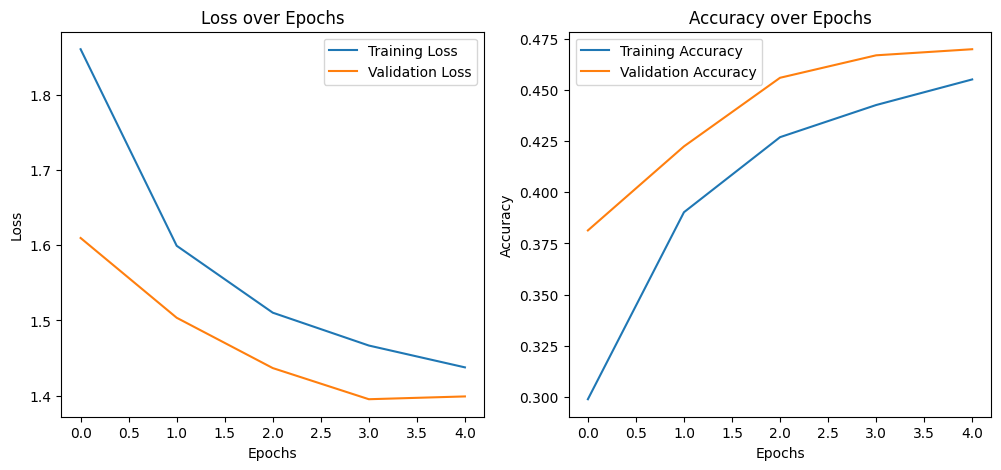

In [10]:
# Extract values from history
epochs = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step


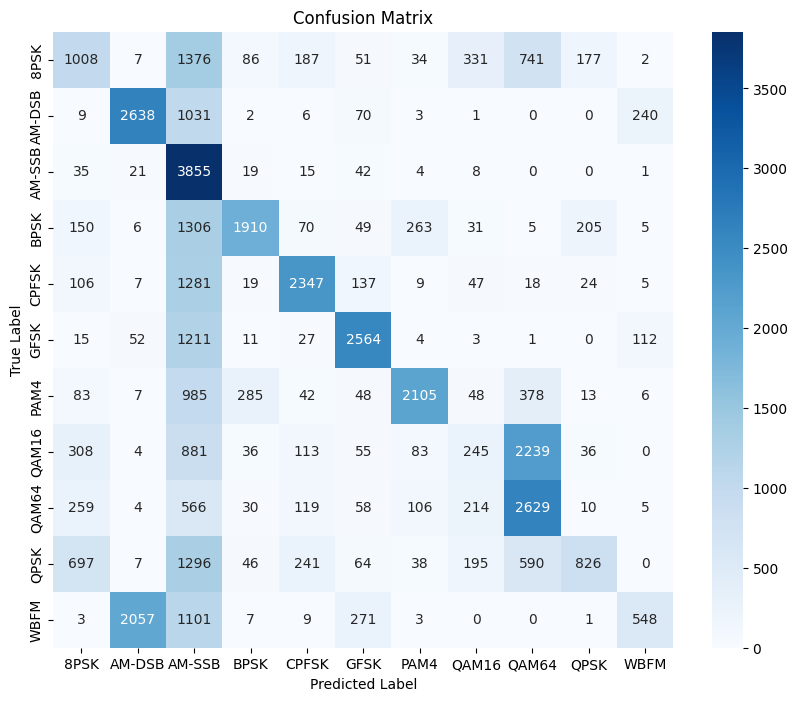

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class index
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()